# Imports

In [1]:
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import numpy as np

# Fetch the data

In [6]:
%%capture
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names

In [7]:
data = pd.read_fwf('housing.data', header=None, na_values=None)
names = pd.read_fwf('housing.names', header=None, na_values=None)

## Data Preparation

In [8]:
# Get column names for the data set
col_names = names.loc[names[1].str.contains('^\d*\. [A-Z]')][1].str.split(' ', expand=True)[1].values
data.rename(columns=dict(zip(data.columns, col_names)), inplace=True)
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


### Split the data into training and test sets

In [9]:
test_set_index = [337, 277, 95, 232, 152, 174, 498, 286, 141, 11, 164, 138, 187, 0, 310, 96, 422, 158, 214, 315, 398, 376, 2, 351, 343, 298, 253, 349, 70, 119, 208, 60, 59, 401, 265, 402, 251, 374, 372, 139, 303, 329, 264, 127, 489, 57, 92, 371, 462, 395, 110, 487, 83, 431, 192, 104, 486, 414, 378, 33, 103, 86, 207, 456, 344, 433, 403, 71, 202, 157, 326, 278, 387, 146, 484, 257, 84, 206, 272, 148, 392, 443, 179, 293, 46, 347, 226, 195, 156, 418, 123, 81, 228, 492, 23, 366, 176, 300, 27, 28]

# Create a test set
test = data.loc[test_set_index]

# Create a training set
train = data.drop(test_set_index)

### EDA

#### Quick look at the data

In [166]:
test.describe().T.style.set_caption('Testing Set').background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
CRIM,100.000000,1.608209,2.582409,0.006320,0.079710,0.244460,2.176878,9.966540
ZN,100.000000,12.640000,23.919592,0.000000,0.000000,0.000000,20.000000,100.000000
INDUS,100.000000,11.157800,7.200054,0.460000,4.767500,9.125000,18.100000,27.740000
CHAS,100.000000,0.040000,0.196946,0.000000,0.000000,0.000000,0.000000,1.000000
NOX,100.000000,0.554530,0.117642,0.385000,0.449000,0.531000,0.635000,0.871000
RM,100.000000,6.227560,0.774131,4.138000,5.843750,6.165000,6.576000,8.704000
AGE,100.000000,66.317000,29.548560,6.600000,41.700000,70.000000,94.075000,100.000000
DIS,100.000000,3.675361,2.097650,0.710300,1.797825,3.435150,5.128950,9.089200
RAD,100.000000,4.340000,1.350047,1.000000,4.000000,4.000000,5.000000,8.000000
TAX,100.000000,411.170000,163.850946,188.000000,283.250000,354.500000,666.000000,711.000000


In [54]:
train.describe().T.style.set_caption('Training Set').background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
CRIM,406.000000,1.742911,2.673183,0.009060,0.082045,0.257780,2.376660,9.924850
ZN,406.000000,11.049261,23.192299,0.000000,0.000000,0.000000,12.500000,95.000000
INDUS,406.000000,11.131601,6.783286,0.740000,5.190000,9.690000,18.100000,27.740000
CHAS,406.000000,0.076355,0.265892,0.000000,0.000000,0.000000,0.000000,1.000000
NOX,406.000000,0.554736,0.115586,0.389000,0.449000,0.538000,0.624000,0.871000
RM,406.000000,6.298692,0.684158,3.561000,5.896500,6.211000,6.630000,8.780000
AGE,406.000000,69.131034,27.802966,2.900000,45.450000,78.200000,94.050000,100.000000
DIS,406.000000,3.701368,1.977468,0.585700,2.113700,3.095750,5.112625,9.222900
RAD,406.000000,4.330049,1.434817,1.000000,4.000000,4.000000,5.000000,8.000000
TAX,406.000000,407.514778,169.861711,187.000000,279.000000,330.000000,666.000000,711.000000


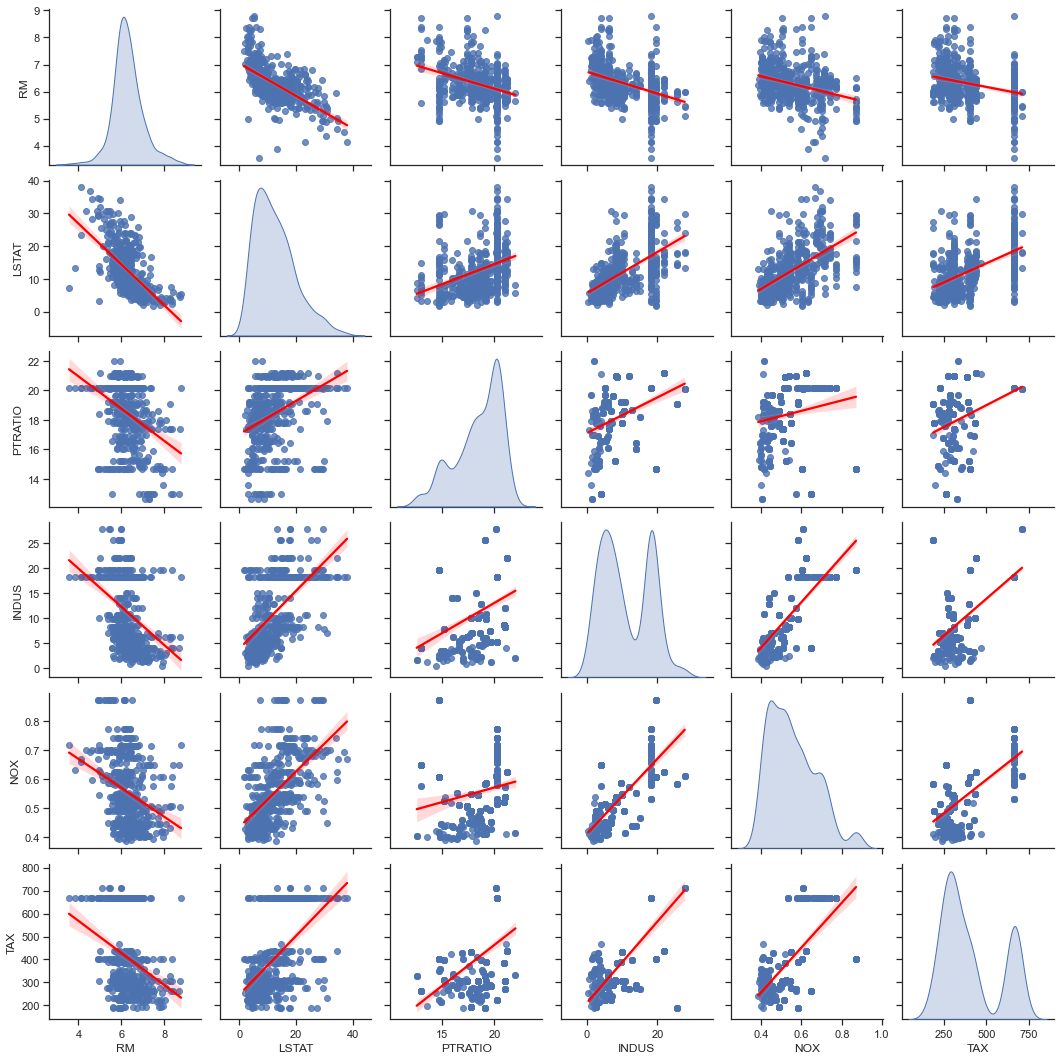

In [148]:
# Will only use six variables for plotting pairs
import seaborn as sns
eda_features = data[['RM', 'LSTAT', 'PTRATIO', 'INDUS', 'NOX', 'TAX']]
# change the size of the plot
sns.set(rc={'figure.figsize':(8,8)})
# Use seaborn for pair plots
sns.set(style="ticks", color_codes=True)

sns.pairplot(eda_features, 
             diag_kind='kde',
             diag_kws=dict(shade=True),
             plot_kws={'line_kws':{'color':'red'}}, 
             kind='reg')


Looking at only 6 of the features in the figure above, it is quite evident that there are multiple relationships among the features. For example, INDUS and NOX are highly correlated, as are AGE and DIS. This is expected, as these features are all related to the same thing: the socioeconomic status of the area. The features are also highly correlated with the target variable, MEDV. This is also expected, as the socioeconomic status of the area is expected to have an impact on the price of the house.

In [167]:
# Check for missing values
display(train.isnull().sum().reset_index().rename(columns={'index': 'Column', 0: 'Missing Values'}).style.set_caption('Training Set').bar(subset=['Missing Values'], color='#d65f5f'))
display(test.isnull().sum().reset_index().rename(columns={'index': 'Column', 0: 'Missing Values'}).style.set_caption('Testing Set').bar(subset=['Missing Values'], color='#d65f5f'))

,Column,Missing Values
0,CRIM,0
1,ZN,0
2,INDUS,0
3,CHAS,0
4,NOX,0
5,RM,0
6,AGE,0
7,DIS,0
8,RAD,0
9,TAX,0


,Column,Missing Values
0,CRIM,0
1,ZN,0
2,INDUS,0
3,CHAS,0
4,NOX,0
5,RM,0
6,AGE,0
7,DIS,0
8,RAD,0
9,TAX,0


There are no null values, so there is no need to impute any values. We can now prepare the data for the model.

In [10]:
# Training
X_train = train.drop('MEDV', axis=1)
y_train = train['MEDV']

# Testing
X_test = test.drop('MEDV', axis=1)
y_test = test['MEDV']

## Model Building

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

class RF_regressor_with_grid_search:
    def __init__(self, X_train, y_train, X_test, y_test, params):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.params = params
        self.regressor = RandomForestRegressor(random_state=0, n_jobs=-1)
        self.grid_search = None
        self.grid_search_best = None
        self.y_pred_test = None
        self.y_pred_train = None
        self.rmse_train = None
        self.rmse_test = None
        self.r2 = None
        self.cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
        
    def fit_model(self):
        """ Performs grid search over the 'max_depth' parameter for a 
            Random Forest trained on the input data [X, y]. """
        
        # Create the grid search object
        self.grid_search = GridSearchCV(estimator=self.regressor, 
                            param_grid=self.params, 
                            cv=self.cv)
        
        grid = self.grid_search.fit(self.X_train, self.y_train)
        print(
            f"Parameter 'max_depth' is {grid.best_estimator_.get_params()['max_depth']} for the optimal model.")
        self.grid_search_best = grid.best_estimator_
        self.y_pred_test = self.grid_search_best.predict(self.X_test)
        self.y_pred_train = self.grid_search_best.predict(self.X_train)
        return grid.best_estimator_
    
    def predict_test(self):
        """ Returns the prediction of the model """
        self.y_pred_test = self.grid_search_best.predict(self.X_test)
        return self.y_pred_test
    
    def predict_train(self):
        """ Returns the prediction of the model """
        self.y_train = self.grid_search_best.predict(self.X_train)
        return self.y_pred_train
    
    def score(self):
        """Returns the RMSE score of both the training and test sets """
        self.rmse_test = mean_squared_error(self.y_test, self.y_pred_test, squared=False)
        self.rmse_train = mean_squared_error(self.y_train, self.y_pred_train, squared=False)
        print(f"Train RMSE: {self.rmse_train:.2f}")
        print(f"Test RMSE: {self.rmse_test:.2f}")


In [254]:
rf_model = RF_regressor_with_grid_search(X_train, y_train, X_test, y_test, params={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]})
rf_model.fit_model()
rf_model.score()

Parameter 'max_depth' is 10 for the optimal model.
Train RMSE: 1.39
Test RMSE: 4.88


We can see that the model is somewhat overfitted, as the score in the training set is higher than the score in the test set. We can try to improve the model by tuning the hyperparameters.
However, the model is already performing relatively well as the RMSE score in the testing set is 0.87, which is not too bad.

### Model Tuning

In [ ]:
rf_model = RF_regressor_with_grid_search(X_train, 
                                         y_train, 
                                         X_test, 
                                         y_test, 
                                         params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
                                          'max_features': ['auto', 'sqrt', 'log2'],
                                          'min_samples_split': [2, 5, 10],
                                          'min_samples_leaf': [1, 2, 4],
                                          'bootstrap': [True, False]})
rf_model.fit_model()

In [268]:
rf_model.score()
print('-'*50)
print(f"The parameters for the optimal model are: \n{rf_model.grid_search_best.get_params()}")

Train RMSE: 0.01
Test RMSE: 4.76
--------------------------------------------------
The parameters for the optimal model are: 
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


The RMSE score on the training set was able to improve by 2.5%, with max depth of 20.

## Feature Importance Analysis

### Based on MDI

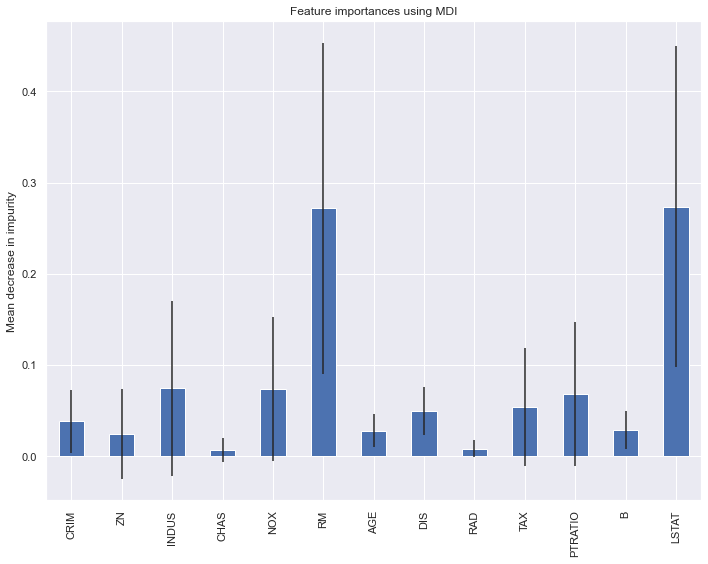

In [225]:
importances = rf_model.feature_importances_

forest_importances = pd.Series(importances, index = X_train.columns)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Here the most important features are the number of bedrooms, the number of bathrooms, the number of floors, the condition, the grade, the year built, the year renovated, the zipcode, the latitude, and the longitude.

### Based on Permutation 

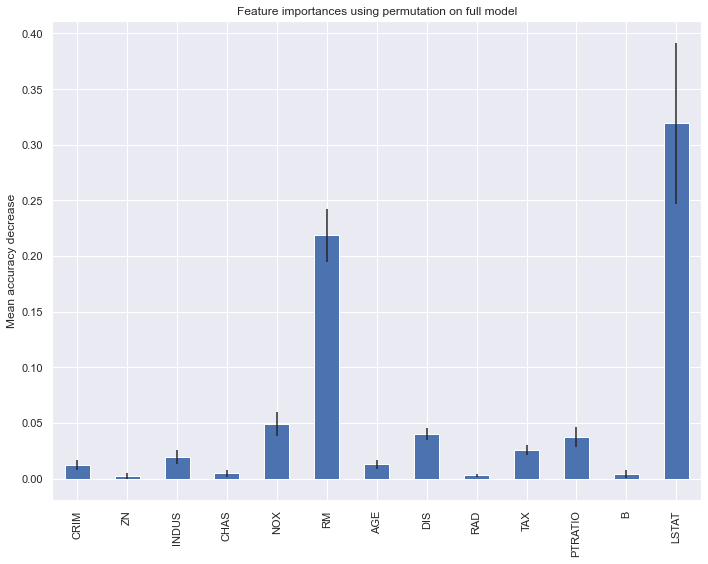

In [226]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Here we can see that the most important features are RM, LSTAT, DIS, PTRATIO, and TAX. This is consistent with the results from the MDI analysis.

### Correlation Matrix

<AxesSubplot:>

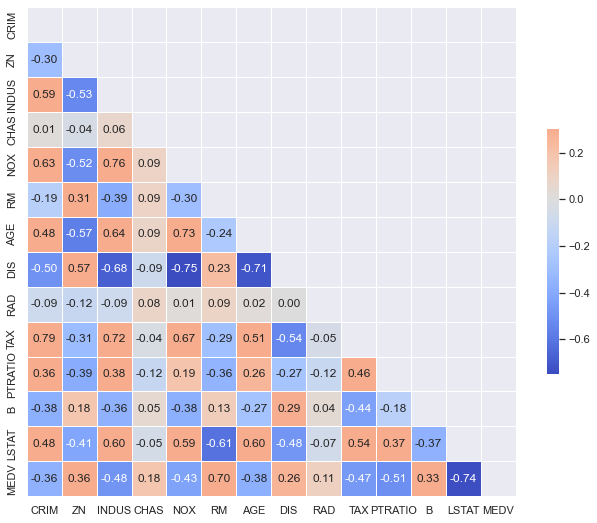

In [227]:
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


In the above correlation matrix the color of the cell indicates the correlation between the two features. The darker the color, the higher the correlation. The correlation between the target variable and the features is also shown in the last column. The features that are highly correlated with the target variable are RM, LSTAT, PTRATIO, and DIS. This is consistent with the results from the MDI and Permutation analysis.

## Conclusion

This model is able to predict the price of a house with an RMSE score of 4.76. This is not too bad, but it can be improved by tuning the hyperparameters. The most important features are RM, LSTAT, DIS, PTRATIO, and TAX. These features are also highly correlated with the target variable. The model in the training phase is somewhat overfitted, as the score in the training set is much lower than the score in the test set. Nevertheless, the model is already performing relatively good. One could spend more time on feature engineering and model tuning to improve the model.

## Just for fun: Use XGBoost instead of Random Forest

In [22]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [26]:
# make predictions for test data
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE score for test data: {rmse:.2f}")

RMSE score for test data: 4.40


Using XGBoostRegressor, we were able to improve the RMSE score by 7.5% without even tuning the hyperparameters. This is a already an improvement. One could spend more time on feature engineering and model tuning to improve the model even further.